In [1]:
import os 
import numpy as np
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from collections import defaultdict
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from time import time
from datetime import timedelta

base_dir = "/kaggle/input/ecg-parse-data"

xtrain_path = os.path.join(base_dir, 'X_train.npy')
ytrain_path = os.path.join(base_dir, 'Y_train.npy')

xval_path = os.path.join(base_dir, 'X_val.npy')
yval_path = os.path.join(base_dir, 'Y_val.npy')

xtest_path = os.path.join(base_dir, 'X_test.npy')
ytest_path = os.path.join(base_dir, 'Y_test.npy')

X_train = np.load(xtrain_path)
Y_train = np.load(ytrain_path)

X_val = np.load(xval_path)
Y_val = np.load(yval_path)

X_test = np.load(xtest_path)
Y_test = np.load(ytest_path)

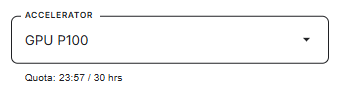

J'ai plus de GPU

In [2]:
class ECG_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float).unsqueeze(0), torch.tensor(self.Y[index], dtype=torch.float).unsqueeze(0)
        
    def __len__(self):
        return len(self.X)
        
class ECG_Autoencoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dropout):
        super().__init__()
        
        self.conv_encoder = nn.Sequential(
            nn.Conv1d(1, d_model//2, kernel_size=15, padding=7),
            nn.BatchNorm1d(d_model//2),
            nn.GELU(),
            nn.Conv1d(d_model//2, d_model, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model),
            nn.GELU(),
        )
        
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=d_model,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        self.decoder = nn.Sequential(
            nn.Conv1d(d_model, d_model//2, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model//2),
            nn.GELU(),
            nn.Conv1d(d_model//2, 1, kernel_size=15, padding=7)
        )

    def forward(self, x):
        # x: [B, 1, 1000]
        x = self.conv_encoder(x)  # [B, d_model, 1000]
        
        # Transformer
        x = x.permute(0, 2, 1)  # [B, 1000, d_model]
        x = self.transformer(x)
        x = x.permute(0, 2, 1)  # [B, d_model, 1000]
        
        return self.decoder(x)

In [3]:
import torch.nn.functional as F

def compute_snr_loss(denoised, clean):
    noise_power = torch.mean((clean - denoised)**2, dim=[1,2])  
    signal_power = torch.mean(clean**2, dim=[1,2])            
    snr = 10 * torch.log10(signal_power / (noise_power + 1e-8))  
    return -torch.mean(snr)

In [4]:
def train(model, logger, dataloader, optimizer, scheduler, scaler, epoch):
    model.train()
    running_loss = defaultdict(float)
    loop = tqdm(dataloader, desc=f"Epoch {epoch} - Training", leave=False)
    
    for ecg_input, ecg_target in loop:  
        ecg_input = ecg_input.to(device, non_blocking=True)  
        ecg_target = ecg_target.to(device)  
        
        optimizer.zero_grad()
        
        with autocast(dtype=torch.float16, device_type='cuda'):
            denoised_ecgs = model(ecg_input)  
            
            total_loss = F.mse_loss(denoised_ecgs, ecg_target)
            #snr_loss = compute_snr_loss(denoised_ecgs, ecg_target)
            #total_loss = 0.5 * snr_loss + 0.5 * mse_loss
        
        scaler.scale(total_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        
        #running_loss['mse_loss'] += mse_loss.item()
        #running_loss['snr_loss'] += snr_loss.item()
        running_loss['total_loss'] += total_loss.item()
        
        loop.set_postfix({
            'total_loss': total_loss.item(),
            'lr': optimizer.param_groups[0]['lr']
        })
    
    running_loss = {k: v/len(dataloader) for k, v in running_loss.items()}
    logger.append({
        **running_loss,
        'lr': optimizer.param_groups[0]['lr']
    })
    
    print(f"Epoch {epoch} - Train Loss: {running_loss['total_loss']:.4f}")
    #print(f"(MSE: {running_loss['mse_loss']:.4f}, SNR: {running_loss['snr_loss']:.2f} dB)")
    scheduler.step()

def evaluate(model, logger, dataloader, scaler, epoch):
    model.eval()
    running_loss = defaultdict(float)
    loop = tqdm(dataloader, desc=f"Epoch {epoch} - Validation", leave=False)
    
    with torch.no_grad():
        for ecg_input, ecg_target in loop:  
            ecg_input = ecg_input.to(device, non_blocking=True)  
            ecg_target = ecg_target.to(device) 
            
            with autocast(dtype=torch.float16, device_type='cuda'):
                denoised_ecgs = model(ecg_input)
                
                total_loss = F.mse_loss(denoised_ecgs, ecg_target)
                #snr_loss = compute_snr_loss(denoised_ecgs, ecg_target)
                #total_loss = 0.5 * snr_loss + 0.5 * mse_loss
            
            running_loss['total_loss'] += total_loss.item()
            #running_loss['mse_loss'] += mse_loss.item()
            #running_loss['snr_loss'] += snr_loss.item()

    
    running_loss = {k: v/len(dataloader) for k, v in running_loss.items()}
    logger.append({
        **running_loss
    })
    
    print(f"Epoch {epoch} - Validation Loss: {running_loss['total_loss']:.4f} ")
    #print(f"(MSE: {running_loss['mse_loss']:.4f}, SNR: {running_loss['snr_loss']:.2f} dB)")

In [5]:
import pandas as pd

if __name__ == "__main__":
    n_epoch = 3
    BATCH_SIZE = 256

    train_ds = ECG_Dataset(X_train, Y_train)
    val_ds = ECG_Dataset(X_val, Y_val)
    test_ds = ECG_Dataset(X_test, Y_test)
    
    train_loader =  DataLoader(train_ds, num_workers=4, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, num_workers=4, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, num_workers=4, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    d_model, n_head, n_layer, dropout = 96, 2, 2, 0.05
    model = ECG_Autoencoder(d_model, n_head, n_layer, dropout) 
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
        
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    scaler = GradScaler()

    train_logger = []
    val_logger = []

    best_loss = 10000
    best_model_path = "/kaggle/working/best_model.pth"
    history = pd.DataFrame()
    
    for epoch in range(n_epoch):
        start_time = time()
        train(model, train_logger, train_loader, optimizer, scheduler, scaler, epoch+1)
        evaluate(model, val_logger, val_loader, scaler, epoch+1)
        end_time = time() - start_time
        time_str = str(timedelta(seconds=end_time)).split(".")[0]
        print(f"Time - {time_str}")

        current_loss = val_logger[-1]['total_loss']
        if current_loss < best_loss:
            print(f"New best model found at epoch {epoch+1} with loss: {current_loss:.4f}")
            best_loss = current_loss
            torch.save(model.state_dict(), best_model_path)

        epoch_data = {
            'epoch': epoch+1,
            **train_logger[-1],
            **val_logger[-1]
        }
        history = pd.concat([history, pd.DataFrame([epoch_data])], ignore_index=True)
        
    history.to_csv("/kaggle/working/training_history.csv", index=False)
    print('Training finished!')

Epoch 1 - Training:   0%|          | 0/818 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.0131


Epoch 1 - Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1 - Validation Loss: 0.0070 
Time - 0:05:56
New best model found at epoch 1 with loss: 0.0070


Epoch 2 - Training:   0%|          | 0/818 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.0049


Epoch 2 - Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2 - Validation Loss: 0.0021 
Time - 0:06:00
New best model found at epoch 2 with loss: 0.0021


Epoch 3 - Training:   0%|          | 0/818 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.0046


Epoch 3 - Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 3 - Validation Loss: 0.0019 
Time - 0:06:03
New best model found at epoch 3 with loss: 0.0019
Training finished!
